# (Denoising) Autoencoder Training on MNIST Images

In [8]:
# Load all relevant modules
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np
from IPython import display
from skimage.util import random_noise

from torchvision import datasets
import torchvision.transforms as T

import res.viz_utils as vu
from res.plot_lib import set_default

set_default()

In [9]:
# Define constants
DATA_DIR = "data"
MODEL_DIR = "models"
BATCH_SIZE = 128
NUM_EPOCH = 1
IS_DENOISING = False # True: Denoising Autoencoder, False: Standard Autoencoder
NOISE_TYPE = "salt" # {"gaussian", "salt"}


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load Training and Test Dataset

In [10]:
# Transform to (-1, 1) 
img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# Load train
train_data = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=img_transform,
)

# Load test
test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=img_transform,
)

In [11]:
# Create data loader
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [12]:
# Define model architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Tanh(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

In [13]:
[n, dx1, dx2] = train_data.data.size()
input_size = dx1 * dx2
hidden_size = 128
model = Autoencoder(input_size, hidden_size).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    lr=1e-3,
    params=model.parameters()
)


### Train Model

Epoch [1/1], loss: 0.0814, elapsed_t:  5.12 secs
 ---- Model models/dae_salt_mnist_z128_ep1.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0


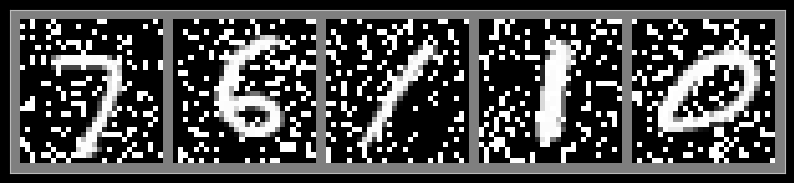

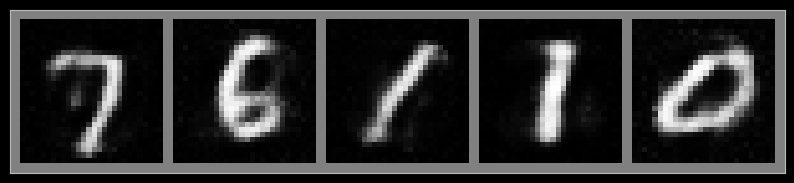

In [14]:
mname = "ae" if not IS_DENOISING else f"dae_{NOISE_TYPE}"
model_path = os.path.join(MODEL_DIR, f"{mname}_mnist_z{hidden_size}_ep{NUM_EPOCH}.pth")

for epoch in range(NUM_EPOCH):
    start_t = timer.time()
    for batch_idx, (X, _) in enumerate(train_loader):
        if IS_DENOISING:
            # Add noise
            # noise = torch.randn_like(X) * 0.2
            # Xn = X + noise
            if NOISE_TYPE == "salt":
                Xn = torch.tensor(random_noise(X, mode=NOISE_TYPE, amount=0.2))
                # print(f'[Salt-and-Pepper Noise] Xn dtype: {Xn.dtype}')
            elif NOISE_TYPE == "gaussian":
                Xn = torch.tensor(random_noise(X, mode=NOISE_TYPE, var=0.5)).to(torch.float32)
                # print(f'[Gaussian Noise] Xn dtype: {Xn.dtype}')
        else:
            Xn = X

        # Feed forward
        X = X.view(-1, input_size).to(DEVICE)
        Xn = Xn.view(-1, input_size).to(DEVICE)
        
        Xr = model(Xn)

        # Compute loss
        loss = criterion(Xr, X)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    # end for
    elapsed_t = timer.time() - start_t

    print(f'Epoch [{epoch+1}/{NUM_EPOCH}], loss: {loss.item():.4f}, elapsed_t: {elapsed_t: 0.2f} secs')

    # Save model
    torch.save(model.state_dict(), model_path)
    print(f" ---- Model {model_path} stored!")

    # Display input images and their reconstructions
    grid_x = vu.set_grid(Xn.view(-1, 1, dx1, dx2).detach().cpu().numpy(), num_cells=5)
    vu.show(grid_x)

    grid_xr = vu.set_grid(Xr.view(-1, 1, dx1, dx2).detach().cpu().numpy(), num_cells=5)
    vu.show(grid_xr)

# end for